# Comparing approaches to forecasting species richness using the Breeding Bird Survey

This project attempts to develop and evaluate a variety of approaches to making relatively short-term forecasts for patterns of species richness in the Breeding Bird Survey of North America data (BBS). BBS is being used as a starting point to develop these forecasts for community ecology more generally.

Forecasting methods currently being used include:

* Naive (last observed value in the time-series)
* Long-term average of value
* ARIMA models
* Spatial environmental linear models (currently just MODIS NDVI)
* Temporal environmental linear models (i.e., regressions fit to time-series at focal site; currently just MODIS NDVI)

Additional modeling approaches to be added include:

* Stacked single-species SDMs
* Joint SDMs
* spatio-temporal models?
* model averaging

In [1]:
library(forecast)
library(Hmisc)
library(dplyr)
library(broom)
library(ggplot2)
library(tidyr)
library(mgcv)
library(lme4)
library(caret)
library(gridExtra)
devtools::load_all()

library(sp)
library(raster)
library(maptools)
library(rgeos)
library(rgdal)
library(maps)
library(viridis)

Loading required package: zoo

Attaching package: ‘zoo’

The following objects are masked from ‘package:base’:

    as.Date, as.Date.numeric

Loading required package: timeDate
This is forecast 7.1 

Loading required package: lattice
Loading required package: survival
Loading required package: Formula
Loading required package: ggplot2

Attaching package: ‘Hmisc’

The following objects are masked from ‘package:base’:

    format.pval, round.POSIXt, trunc.POSIXt, units


Attaching package: ‘dplyr’

The following objects are masked from ‘package:Hmisc’:

    combine, src, summarize

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union

Loading required package: nlme

Attaching package: ‘nlme’

The following object is masked from ‘package:dplyr’:

    collapse

The following object is masked from ‘package:forecast’:

    getResponse

This is mgcv 1.8-11. For overview type 'hel

## Initial data setup

Load the BBS data and limit it to sites with contiguous time-series from 2000 to 2014 (the range spanned by the MODIS data).

In [2]:
start_yr <- 1982
end_yr <- 2013
min_num_yrs <- 25
richness_w_env <- get_richness_ts_env_data(start_yr, end_yr, min_num_yrs)

In [3]:
head(richness_w_env)
cat("There are", length(unique(richness_w_env$site_id)), "time-series with at least", min_num_yrs, "years of data between", start_yr, "and", end_yr)

site_id year richness      lat      long     bio1     bio2     bio4  bio5
1    2001 1982       49 34.86869 -87.60414 15.61292 12.14583 765.1609 32.16
2    2001 1983       49 34.86869 -87.60414 15.09625 12.04250 878.9235 34.43
3    2001 1984       65 34.86869 -87.60414 15.85250 12.64833 781.2187 31.32
4    2001 1985       54 34.86869 -87.60414 15.53250 11.97000 890.2069 31.51
5    2001 1986       54 34.86869 -87.60414 16.46875 12.54750 807.5210 34.10
6    2001 1987       58 34.86869 -87.60414 16.22125 13.25250 820.2997 34.53
   bio6 ⋯    bio10    bio11  bio16  bio17  bio18  bio19  ndvi_sum  ndvi_win
1 -2.91 ⋯ 24.05833 7.175000 441.84 283.30 286.50 398.77 0.6876667 0.3658333
2 -2.53 ⋯ 25.52667 6.635000 711.89 142.71 142.71 337.97 0.6436667 0.3960000
3 -4.04 ⋯ 23.98667 6.451667 428.11 119.76 119.76 275.45 0.7241667 0.3691667
4 -5.30 ⋯ 23.98833 5.711667 301.03 231.92 301.03 257.06 0.7206667 0.4165000
5 -2.99 ⋯ 25.57333 8.130000 567.99 195.05 245.44 195.05 0.6470000 0.4115000
6 -1.33 ⋯ 25.43000 7.775000 337.10 205.35 238.25 337.10 0.6966667 0.4085000
   ndvi_ann    elevs
1 0.5605000 210.1263
2 0.5488333 210.1263
3 0.5650000 210.1263
4 0.5950000 210.1263
5 0.5732083 210.1263
6 0.5788750 210.1263

There are 669 time-series with at least 25 years of data between 1982 and 2013

## Maps of variables

In [4]:
states <- map_data("state")
map_year = 2009 #pick a year to map

richness_w_env_oneyear <- dplyr::filter(richness_w_env, year == map_year) %>%
  na.omit()
map_richness <- ggplot() +
  geom_polygon(data=states, aes(x=long, y=lat, group=group), color="black", fill="white") +
  geom_point(data=richness_w_env_oneyear, aes(x=long, y=lat, color=richness)) +
  scale_color_viridis() +
  coord_map()
ggsave("figures/map_richness.png", map_richness)

env_oneyear_long <- tidyr::gather(richness_w_env_oneyear, env_var, value, bio1:elevs)
maps_env_vars <- env_oneyear_long %>%
  group_by(env_var) %>%
  do(plots=ggplot() +
    geom_polygon(data=states, aes(x=long, y=lat, group=group), color="black", fill="white") +
    geom_point(data=., aes(x=long, y=lat, color=value)) +
    scale_color_viridis() +
    coord_map() +
    ggtitle(first(.$env_var))
    )
multi_panel_fig <- do.call("arrangeGrob", c(maps_env_vars$plots, ncol=4))
ggsave("figures/map_env_vars.png", multi_panel_fig, width = 20, height = 20)

Saving 6.67 x 6.67 in image


### Map of Richness

![](figures/map_richness.png)

### Map of Environmental Variables

![](figures/map_env_vars.png)

## Forecasting

Generate forecasts for naive, average, and ARIMA time-series models for each site.

In [5]:
lag <- 10
richness_by_site <- group_by(richness_w_env, site_id)
tsmodel_forecasts <- get_ts_forecasts(richness_by_site, timecol = 'year',
                                      responsecol = 'richness',
                                      exogcols = c("ndvi_sum", "ndvi_win"), lag = lag, pred_int_levels=seq(1, 99, by=1))
head(tsmodel_forecasts$pt_est)
head(tsmodel_forecasts$intervals)

Warning message:
In ets(get_train_data(., responsecol)): Missing values encountered. Using longest contiguous portion of time seriesWarning message:
In ets(get_train_data(., responsecol)): Missing values encountered. Using longest contiguous portion of time seriesWarning message:
In ets(get_train_data(., responsecol)): Missing values encountered. Using longest contiguous portion of time seriesWarning message:
In ets(get_train_data(., responsecol)): Missing values encountered. Using longest contiguous portion of time seriesWarning message:
In ets(get_train_data(., responsecol)): Missing values encountered. Using longest contiguous portion of time seriesWarning message:
In ets(get_train_data(., responsecol)): Missing values encountered. Using longest contiguous portion of time seriesWarning message:
In ets(get_train_data(., responsecol)): Missing values encountered. Using longest contiguous portion of time seriesWarning message:
In ets(get_train_data(., responsecol)): Missing values enco

site_id model timeperiod obs pt_fcast
1    2001 naive       2004  58       63
2    2001 naive       2005  56       63
3    2001 naive       2006  62       63
4    2001 naive       2007  60       63
5    2001 naive       2008  59       63
6    2001 naive       2009  55       63

site_id model timeperiod obs pt_fcast levels       lo       hi
1    2001 arima       2004  58     56.7      1 56.64461 56.75539
2    2001 arima       2004  58     56.7     10 56.14462 57.25538
3    2001 arima       2004  58     56.7     11 56.08874 57.31126
4    2001 arima       2004  58     56.7     12 56.03277 57.36723
5    2001 arima       2004  58     56.7     13 55.97669 57.42331
6    2001 arima       2004  58     56.7     14 55.92049 57.47951

## Spatial environment-richness model prediction

### White & Hurlbert 2010 linear model

In [6]:
richness_w_env_2003 <- filter(richness_w_env, year == 2003)
richness_w_env_pre_2004 <- filter(richness_w_env, year <= 2003)
richness_w_env_2004_2013 <- filter(richness_w_env, year >= 2004)
spatial_bioclim_model_2003 <- lm(richness ~ bio10 + I(bio10^2) + bio11 +
                      I(bio11^2) + bio12 + I(bio12^2), data = richness_w_env_2003)
spatial_env_model_2003 <- lm(richness ~ ndvi_sum + I(ndvi_sum^2) + ndvi_win + I(ndvi_win^2) + bio10 + I(bio10^2) + bio11 +
                      I(bio11^2) + bio12 + I(bio12^2) + elevs + I(elevs^2), data = richness_w_env_pre_2004)
fcast_spatial_bioclim <- forecast(spatial_bioclim_model_2003, newdata = richness_w_env_2004_2013)
fcast_spatial_env <- forecast(spatial_env_model_2003, newdata = richness_w_env_2004_2013, level = seq(1, 99, by=1))
fcast_spatial_bioclim_data <- cbind(richness_w_env_2004_2013, fcast_spatial_bioclim)
fcast_spatial_env_data <- cbind(richness_w_env_2004_2013, fcast_spatial_env)

fcast_spatial_bioclim_data$model <- 'spat_bioclim'
fcast_spatial_bioclim <- dplyr::select(fcast_spatial_bioclim_data,
                                   site_id, model, timeperiod = year, obs = richness,
                                   everything(), -lat, -long, -starts_with("bio"),
                                   -starts_with("ndvi"), -elevs)
fcast_spatial_bioclim <- restruct_ts_forecasts(fcast_spatial_bioclim)

fcast_spatial_env_data$model <- 'spat_env'
fcast_spatial_env <- dplyr::select(fcast_spatial_env_data,
                                   site_id, model, timeperiod = year, obs = richness,
                                   everything(), -lat, -long, -starts_with("bio"),
                                   -starts_with("ndvi"), -elevs)
fcast_spatial_env <- restruct_ts_forecasts(fcast_spatial_env)

head(fcast_spatial_env$pt_est)
head(fcast_spatial_env$intervals)

site_id    model timeperiod obs pt_fcast
1    2001 spat_env       2004  58 50.85210
2    2001 spat_env       2005  56 48.36500
3    2001 spat_env       2006  62 48.52880
4    2001 spat_env       2007  60 48.20163
5    2001 spat_env       2008  59 51.46744
6    2001 spat_env       2009  55 50.97243

site_id    model timeperiod obs pt_fcast levels       lo       hi
1    2001 spat_env       2004  58  50.8521      1 50.74130 50.96290
2    2001 spat_env       2004  58  50.8521     10 49.74121 51.96298
3    2001 spat_env       2004  58  50.8521     11 49.62945 52.07475
4    2001 spat_env       2004  58  50.8521     12 49.51748 52.18671
5    2001 spat_env       2004  58  50.8521     13 49.40531 52.29889
6    2001 spat_env       2004  58  50.8521     14 49.29290 52.41130

### GAM

In [7]:
high_corr_vars <- colnames(richness_w_env_pre_2004)[findCorrelation(cor(richness_w_env_pre_2004, use = "complete.obs"))]
cat("The following highly correlated variables are remove from GAM & LME modeling: ", high_corr_vars)

The following highly correlated variables are remove from GAM & LME modeling:  bio11 bio1 bio7 bio16

#### Environmental smoothers

In [8]:
spatial_env_gam_model <- gam(richness ~ s(ndvi_sum, bs = "ts") + s(ndvi_win, bs = "ts") + s(elevs, bs = "ts") +
                            s(bio2, bs = "ts") + s(bio3, bs = "ts") + s(bio4, bs = "ts") + s(bio5, bs = "ts") + s(bio6, bs = "ts") +
                            s(bio8, bs = "ts") + s(bio9, bs = "ts") + s(bio10, bs = "ts") + s(bio12, bs = "ts") + s(bio13, bs = "ts") +
                            s(bio14, bs = "ts") + s(bio15, bs = "ts") + s(bio17, bs = "ts") + s(bio18, bs = "ts") + s(bio19, bs = "ts"),
                            family = gaussian, data = richness_w_env_pre_2004
                            )
pt_fcast <- predict(spatial_env_gam_model, newdata = richness_w_env_2004_2013)
fcast_spatial_env_gam <- dplyr::select(fcast_spatial_env$pt_est, site_id, model, timeperiod, obs) %>%
  mutate(model="spat_env_gam") %>%
  cbind(pt_fcast)

#### Spatial smoother

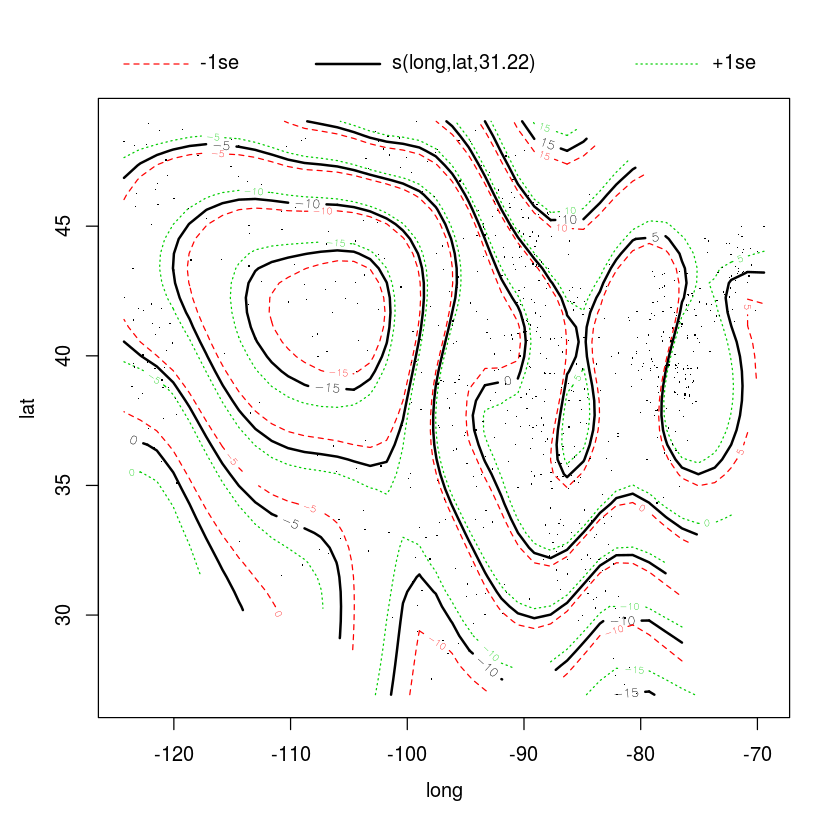

In [9]:
spatial_env_gam_spatial_model <- gam(richness ~ ndvi_sum + ndvi_win + elevs +
                            bio2 + bio3 + bio4 + bio5 + bio6 + 
                            bio8 + bio9 + bio10 + bio12 + bio13 +
                            bio14 + bio15 + bio17 + bio18 + bio19 +
                            s(long, lat, bs = "ds"),
                            family = gaussian, data = richness_w_env_pre_2004
                            )
pt_fcast <- predict(spatial_env_gam_spatial_model, newdata = richness_w_env_2004_2013)
fcast_spatial_env_gam_spatial <- dplyr::select(fcast_spatial_env$pt_est, site_id, model, timeperiod, obs) %>%
  mutate(model="spat_env_gam_spat") %>%
  cbind(pt_fcast)
plot(spatial_env_gam_spatial_model)

### Linear mixed-effects

In [10]:
spatial_env_lme_model <- lmer(richness ~ ndvi_sum + ndvi_win + elevs +
                              bio2 + bio3 + bio4 + bio5 + bio6 + 
                              bio8 + bio9 + bio10 + bio12 + bio13 +
                              bio14 + bio15 + bio17 + bio18 + bio19 + (1|site_id),
                              data = richness_w_env_pre_2004)
pt_fcast <- predict(spatial_env_lme_model, newdata = richness_w_env_2004_2013)
fcast_spatial_env_lme <- dplyr::select(fcast_spatial_env$pt_est, site_id, model, timeperiod, obs) %>%
  mutate(model="spat_env_lme") %>%
  cbind(pt_fcast)

Warning message:
: Some predictor variables are on very different scales: consider rescaling

In [11]:
summary(spatial_env_lme_model)
var(richness_w_env_pre_2004$richness, na.rm = TRUE)


Correlation matrix not shown by default, as p = 19 > 12.
Use print(obj, correlation=TRUE)  or
	 vcov(obj)	 if you need it



Linear mixed model fit by REML ['lmerMod']
Formula: richness ~ ndvi_sum + ndvi_win + elevs + bio2 + bio3 + bio4 +  
    bio5 + bio6 + bio8 + bio9 + bio10 + bio12 + bio13 + bio14 +  
    bio15 + bio17 + bio18 + bio19 + (1 | site_id)
   Data: richness_w_env_pre_2004

REML criterion at convergence: 82740.3

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-5.4463 -0.5709  0.0154  0.6035  4.8789 

Random effects:
 Groups   Name        Variance Std.Dev.
 site_id  (Intercept) 89.42    9.456   
 Residual             22.58    4.752   
Number of obs: 13382, groups:  site_id, 669

Fixed effects:
              Estimate Std. Error t value
(Intercept) 53.3834821  2.6635921  20.042
ndvi_sum    10.6434279  1.3076618   8.139
ndvi_win     6.4567462  1.2412912   5.202
elevs       -0.0048659  0.0007963  -6.111
bio2         0.1225478  0.1695800   0.723
bio3        -0.1453126  0.0566397  -2.566
bio4         0.0020200  0.0011260   1.794
bio5        -0.3384564  0.0714537  -4.737
bio6         0.220

[1] 137.3854


## Assembling forecasts from different approaches

In [12]:
forecasts = list()
forecasts$pt_est <- bind_rows(tsmodel_forecasts$pt_est, fcast_spatial_env$pt_est, fcast_spatial_env_gam, fcast_spatial_env_gam_spatial, fcast_spatial_env_lme) %>%
  group_by(site_id) %>%
  filter(min(timeperiod) == 2004, max(timeperiod) == 2013) #a couple of sites have missing environmental data for forecast years, which is currently breaking things a little

#TODO: Make interval predictions for other spatial models and add
forecasts$intervals <- bind_rows(tsmodel_forecasts$intervals, fcast_spatial_env$intervals) %>%
  group_by(site_id) %>%
  filter(min(timeperiod) == 2004, max(timeperiod) == 2013) #a couple of sites have missing environmental data for forecast years, which is currently breaking things a little

Warning message:
: Grouping rowwise data frame strips rowwise nature

## Example single site forecast

### General notes

* rapid changes in S not uncommon in last five years
* common for last 5 years S vs. NDVI relationship to differ subsustantially from first 20 years

[1] 61089


Warning message:
: Removed 6 rows containing missing values (geom_point).

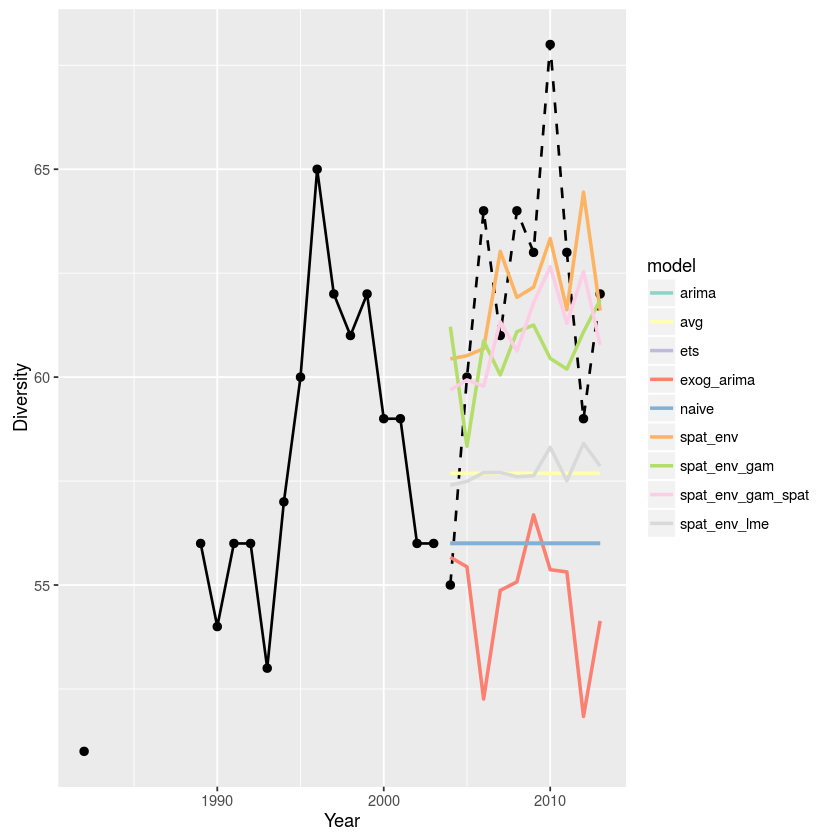

In [13]:
sites <- unique(richness_w_env$site_id)
focal_site <- sample(sites, 1)
print(focal_site)
viz_forecast(richness_w_env, forecasts$pt_est, focal_site)

## Comparison of forecasting approaches

In [14]:
obs_pred_by_method_lag <- ggplot(forecasts$pt_est, aes(x = pt_fcast, y = obs)) +
    geom_point(alpha = 0.25) +
    facet_grid(model ~ timeperiod) +
    theme(aspect.ratio = 1) +
    ggtitle("Observed-predicted plots by method and lag")
ggsave("figures/obs_pred_by_method_lag.png", obs_pred_by_method_lag)

Saving 6.67 x 6.67 in image
Warning message:
: Removed 4590 rows containing missing values (geom_point).

![](figures/obs_pred_by_method_lag.png)

In [15]:
model_accuracies <- group_by(forecasts$pt_est, site_id, model) %>%
                    do(get_error_measures(.$obs, .$pt_fcast))
head(model_accuracies, 10)

site_id             model         ME      RMSE       MAE        MPE
1     2001             arima  2.5000000  4.382921  3.320000  3.8779728
2     2001               avg  2.5000000  4.382921  3.320000  3.8779728
3     2001               ets  2.2108304  4.224662  3.204332  3.3877512
4     2001        exog_arima  0.4607295  3.894829  3.372316  0.4410389
5     2001             naive -3.8000000  5.234501  4.600000 -6.8022524
6     2001          spat_env  9.0897058  9.760624  9.089706 15.0784051
7     2001      spat_env_gam  8.8053278  9.724378  8.805328 14.6062487
8     2001 spat_env_gam_spat  4.6875044  5.963752  4.881451  7.5881108
9     2001      spat_env_lme  2.3213326  4.241366  3.297615  3.5834392
10    2007             arima 10.5454545 12.347332 10.545455 18.0192177
        MAPE
1   5.364336
2   5.364336
3   5.187695
4   5.643383
5   8.023843
6  15.078405
7  14.606249
8   7.940741
9   5.349357
10 18.019218

In [16]:
cbPalette <- c("#F0E442", "#D55E00", "#E69F00", "#56B4E9", "#009E73", "#0072B2", "#999999", "#CC79A7")
# rearranged from http://www.cookbook-r.com/Graphs/Colors_%28ggplot2%29/#a-colorblind-friendly-palette

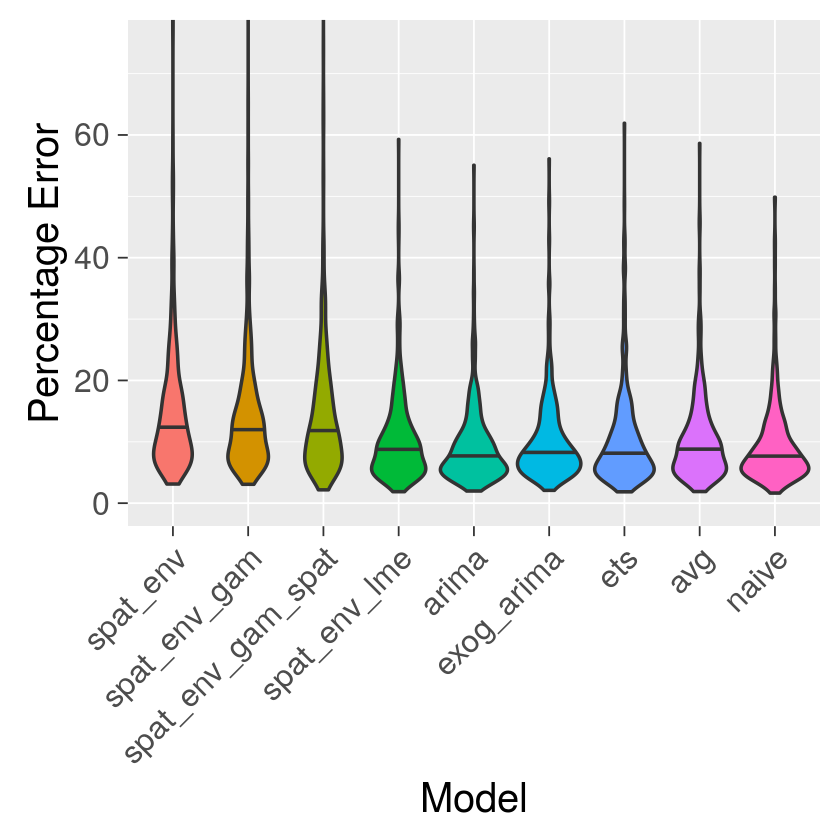

In [17]:
model_accuracies$model = with(model_accuracies, factor(model, levels = c("spat_env", "spat_env_gam", "spat_env_gam_spat", "spat_env_lme", "arima", "exog_arima", "ets", "avg", "naive")))
accuracy_by_model_violins <- ggplot(model_accuracies, aes(model, MAPE)) +
     geom_violin(aes(fill = model), draw_quantiles = c(0.5), size = 1) +
     coord_cartesian(ylim = c(0,75)) +
     labs(x = "Model", y = "Percentage Error") +
     #scale_x_discrete(labels=c("Spatial Env", "Spatial Env GAM", "Spatial Env GAM Spatial", "Spatial Env LME", "Time-series", "Time-series+Env", "Average", "Naive")) +
     scale_color_brewer("Set3") + 
     theme_grey(base_size = 24) +
     guides(fill=FALSE) +
     theme(axis.text.x = element_text(angle = 45, vjust = 1, hjust=1))
ggsave(accuracy_by_model_violins, file = 'figures/accuracy_by_model_violins.png', width = 7, height = 7)
accuracy_by_model_violins

In [18]:
model_accuracies_by_year <- group_by(forecasts$pt_est, site_id, model, timeperiod) %>%
                    do(get_error_measures(.$obs, .$pt_fcast))
model_accuracies_by_year$model = with(model_accuracies_by_year, factor(model, levels = c("spat_env", "spat_env_gam", "spat_env_gam_spat", "spat_env_lme", "arima", "exog_arima", "ets", "avg", "naive")))
head(model_accuracies_by_year)

site_id model timeperiod   ME RMSE MAE       MPE     MAPE
1    2001 arima       2004  1.3  1.3 1.3  2.241379 2.241379
2    2001 arima       2005 -0.7  0.7 0.7 -1.250000 1.250000
3    2001 arima       2006  5.3  5.3 5.3  8.548387 8.548387
4    2001 arima       2007  3.3  3.3 3.3  5.500000 5.500000
5    2001 arima       2008  2.3  2.3 2.3  3.898305 3.898305
6    2001 arima       2009 -1.7  1.7 1.7 -3.090909 3.090909

Warning message:
: Removed 4590 rows containing non-finite values (stat_summary).Warning message:
: Removed 4590 rows containing non-finite values (stat_summary).

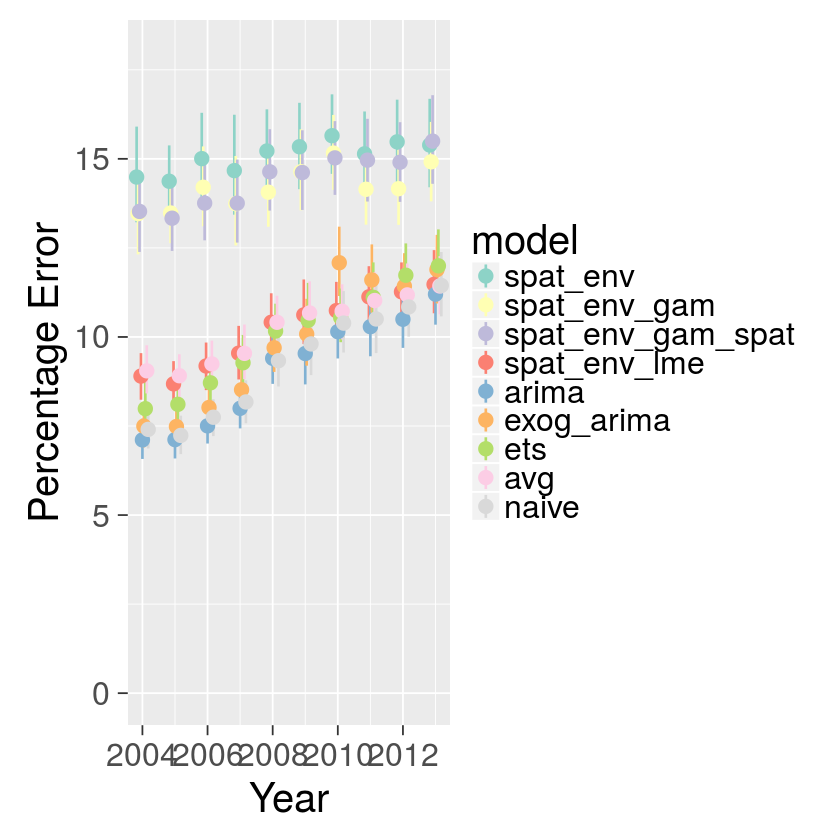

In [19]:
model_accuracies_by_year_plot <- ggplot(model_accuracies_by_year, aes(x = timeperiod, y = MAPE, color = model)) +
    stat_summary(fun.data = "mean_cl_boot", position=position_dodge(width = 0.4), size=0.75) +
     labs(x = "Year", y = "Percentage Error") +
     coord_cartesian(ylim = c(0, 18), xlim = c(2004,2013)) +
     scale_color_brewer(palette = "Set3") +
     theme_grey(base_size = 24)

ggsave(model_accuracies_by_year_plot, file = "figures/model_accuracies_by_year.png", height = 5, width = 7)
model_accuracies_by_year_plot

## Forecast Coverage

Evaluate how well the 95% forecast intervals work

In [20]:
head(forecasts$intervals)

site_id model timeperiod obs pt_fcast levels       lo       hi
1    2001 arima       2004  58     56.7      1 56.64461 56.75539
2    2001 arima       2004  58     56.7     10 56.14462 57.25538
3    2001 arima       2004  58     56.7     11 56.08874 57.31126
4    2001 arima       2004  58     56.7     12 56.03277 57.36723
5    2001 arima       2004  58     56.7     13 55.97669 57.42331
6    2001 arima       2004  58     56.7     14 55.92049 57.47951

In [21]:
pred_interval_results <- forecasts$intervals %>%
                           group_by(model, levels) %>%
                           na.omit() %>%
                           summarize(coverage = sum(obs > lo & obs < hi) / n())
head(pred_interval_results)

model levels   coverage
1 arima      1 0.02571942
2 arima      2 0.03129496
3 arima      3 0.03758993
4 arima      4 0.04424460
5 arima      5 0.05107914
6 arima      6 0.05989209

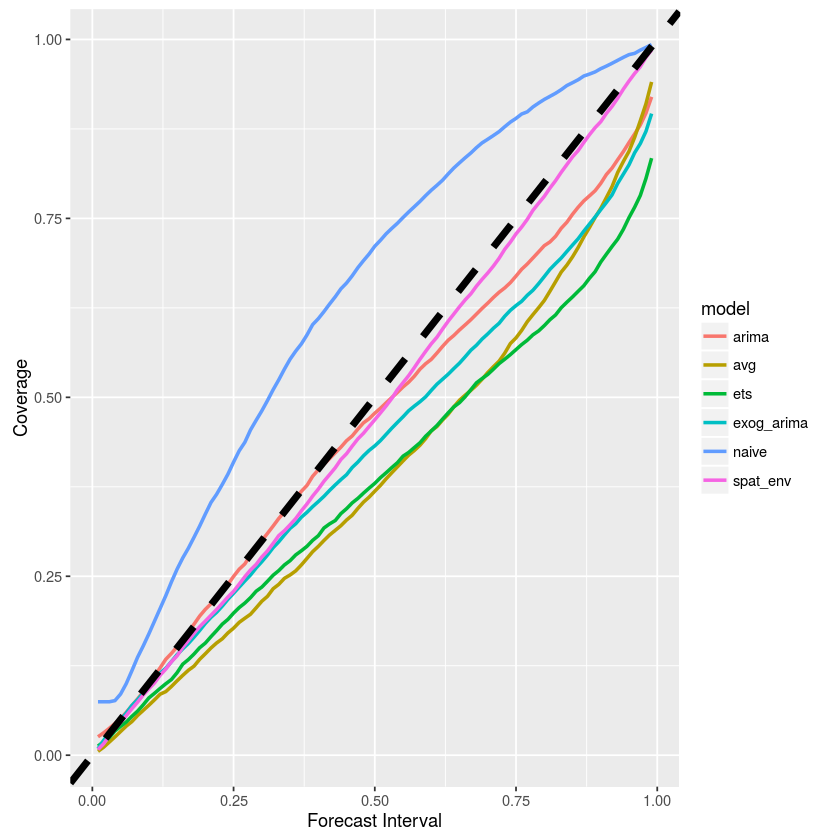

In [22]:
ggplot(pred_interval_results, aes(x = levels / 100, y = coverage, color = model)) +
  geom_line(size = 1) +
  geom_abline(intercept = 0, slope = 1, size = 2, linetype = "dashed") +
  xlab("Forecast Interval") +
  ylab("Coverage")

## Trends in Richness & Environment

In [23]:
trends <- richness_w_env %>%
  group_by(site_id) %>%
  na.omit() %>%
  summarize(trend_rich = cor(richness, year), trend_ndvi_ann = cor(ndvi_ann, year), ndvi_rich_corr = cor(richness, ndvi_ann))
head(trends)

site_id trend_rich trend_ndvi_ann ndvi_rich_corr
1    2001  0.3501663      0.6648884     0.14431650
2    2007  0.7086010      0.5167732     0.22745672
3    2010  0.7316861      0.6438039     0.51428194
4    2014  0.2679702      0.5370923     0.10646332
5    2015  0.3213840      0.3299191     0.37954197
6    2017 -0.4071651      0.6562717    -0.09613597

Saving 6.67 x 6.67 in image
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
Saving 6.67 x 6.67 in image
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


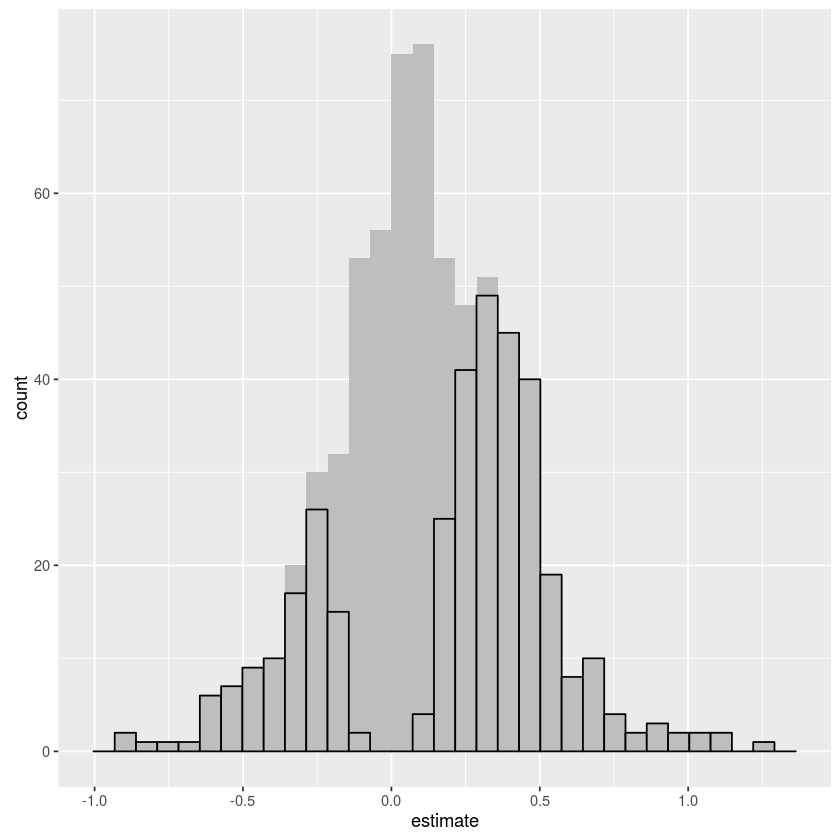

In [24]:
trends <- richness_w_env %>%
  group_by(site_id) %>%
  na.omit() %>%
  do(tidy(lm(richness ~ year, data = .))) %>%
  filter(term == 'year')
trends$adj_pval <- p.adjust(trends$p.value, method = 'fdr')
trends_rich_plot <- ggplot(trends, aes(x = estimate)) +
  geom_histogram(fill = 'gray')
trends_rich_sig_plot <- ggplot(trends, aes(x = estimate)) +
  geom_histogram(fill = 'gray') + 
  geom_histogram(data = filter(trends, adj_pval < 0.05), fill = 'gray', color = 'black')

ggsave(trends_rich_plot, file = "figures/trends_rich_plot.png")
ggsave(trends_rich_sig_plot, file = "figures/trends_rich_sig_plot.png")
trends_rich_sig_plot

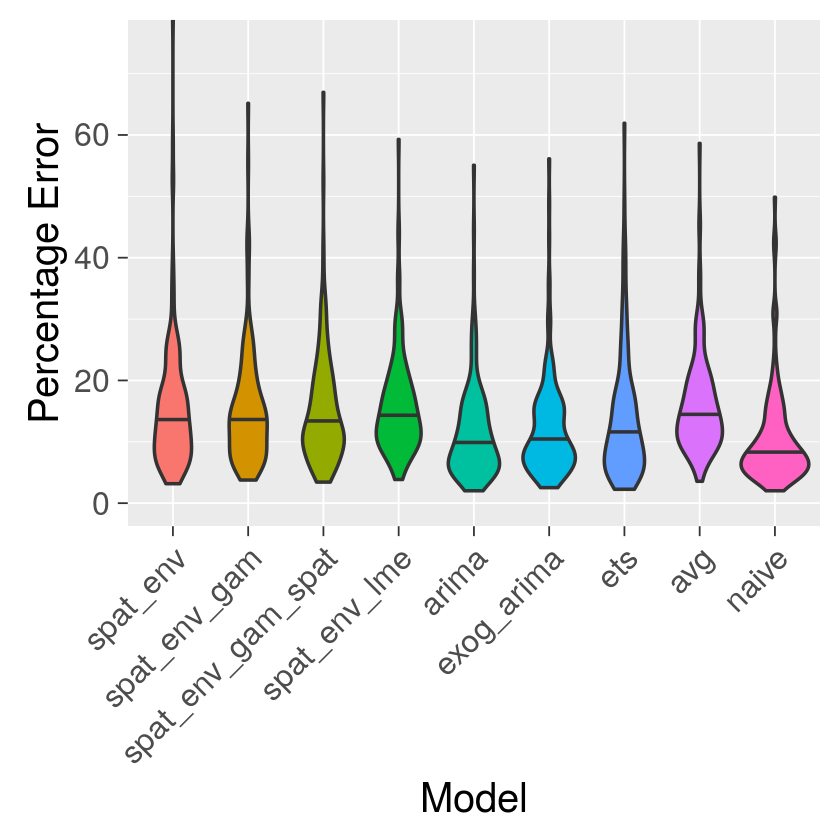

In [25]:
sig_sites <- trends %>%
  filter(adj_pval < 0.05, estimate > 0.333 | estimate < -0.333) %>%
  dplyr::select(site_id)
model_accuracies_sig <- filter(model_accuracies, site_id %in% sig_sites$site_id)

sig_accuracy_by_model_violins <- ggplot(model_accuracies_sig, aes(model, MAPE)) +
     geom_violin(aes(fill = model), draw_quantiles = c(0.5), size = 1) +
     coord_cartesian(ylim = c(0,75)) +
     labs(x = "Model", y = "Percentage Error") +
#     scale_x_discrete(labels=c("Spatial Env", "Time-series", "Time-series+Env", "Average", "Naive")) +
#     scale_fill_manual(values = cbPalette) + 
     scale_color_brewer("Set3") +
     theme_grey(base_size = 24) +
     guides(fill=FALSE) +
     theme(axis.text.x = element_text(angle = 45, vjust = 1, hjust=1))
ggsave(sig_accuracy_by_model_violins, file = 'figures/sig_accuracy_by_model_violins.png', width = 7, height = 7)
sig_accuracy_by_model_violins

## Comparison of bioclim and simple environmental model

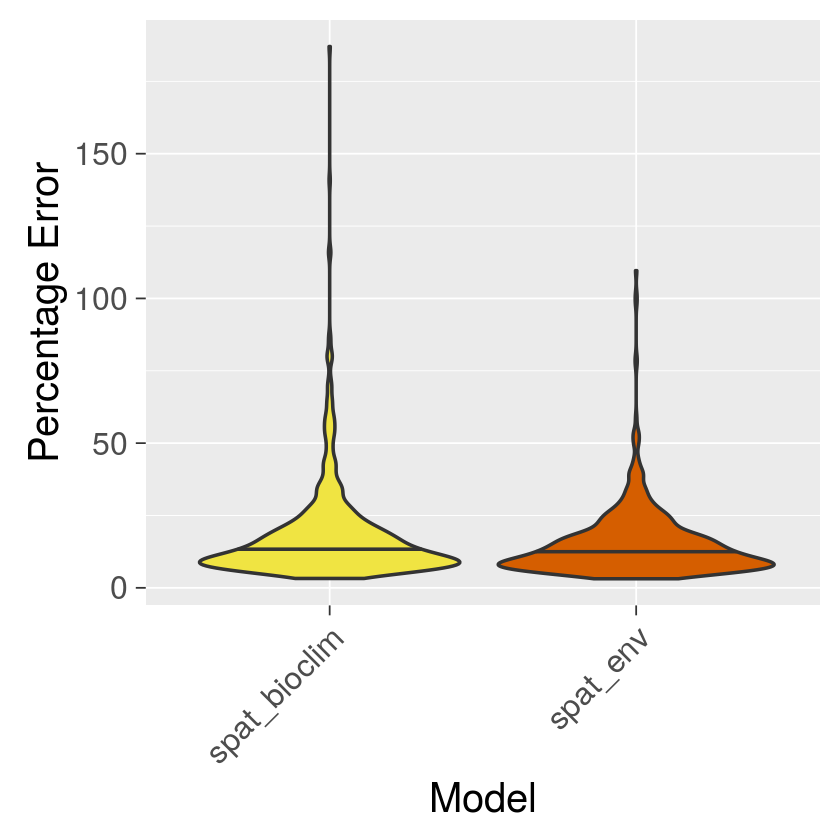

In [26]:
forecasts_spatial <- rbind(fcast_spatial_bioclim$pt_est, fcast_spatial_env$pt_est) %>%
  group_by(site_id) %>%
  filter(min(timeperiod) == 2004, max(timeperiod) == 2013)

model_accuracies_spatial <- group_by(forecasts_spatial, site_id, model) %>%
  do(get_error_measures(.$obs, .$pt_fcast))

ggplot(model_accuracies_spatial, aes(model, MAPE)) +
     geom_violin(aes(fill = model), draw_quantiles = c(0.5), size = 1) +
     #coord_cartesian(ylim = c(0,75)) +
     labs(x = "Model", y = "Percentage Error") +
     #scale_x_discrete(labels=c("Spatial Env", "Time-series", "Time-series+Env", "Average", "Naive")) +
     scale_fill_manual(values = cbPalette) + 
     theme_grey(base_size = 24) +
     guides(fill=FALSE) +
     theme(axis.text.x = element_text(angle = 45, vjust = 1, hjust=1))

## Models combining spatial & temporal information

In [27]:
richness_w_env_prev_yr_rich <- richness_w_env %>%
  dplyr::select(site_id, year, prev_yr_rich=richness) %>%
  mutate(year = year + 1) %>%
  inner_join(richness_w_env, by = c("site_id", "year"))
head(richness_w_env_prev_yr_rich)

site_id year prev_yr_rich richness      lat      long     bio1     bio2
1    2001 1983           49       49 34.86869 -87.60414 15.09625 12.04250
2    2001 1984           49       65 34.86869 -87.60414 15.85250 12.64833
3    2001 1985           65       54 34.86869 -87.60414 15.53250 11.97000
4    2001 1986           54       54 34.86869 -87.60414 16.46875 12.54750
5    2001 1987           54       58 34.86869 -87.60414 16.22125 13.25250
6    2001 1988           58       65 34.86869 -87.60414 15.46167 13.32833
      bio4  bio5 ⋯    bio10    bio11  bio16  bio17  bio18  bio19  ndvi_sum
1 878.9235 34.43 ⋯ 25.52667 6.635000 711.89 142.71 142.71 337.97 0.6436667
2 781.2187 31.32 ⋯ 23.98667 6.451667 428.11 119.76 119.76 275.45 0.7241667
3 890.2069 31.51 ⋯ 23.98833 5.711667 301.03 231.92 301.03 257.06 0.7206667
4 807.5210 34.10 ⋯ 25.57333 8.130000 567.99 195.05 245.44 195.05 0.6470000
5 820.2997 34.53 ⋯ 25.43000 7.775000 337.10 205.35 238.25 337.10 0.6966667
6 862.0546 33.81 ⋯ 25.45167 5.990000 395.60 164.45 297.40 226.84 0.6538333
   ndvi_win  ndvi_ann    elevs
1 0.3960000 0.5488333 210.1263
2 0.3691667 0.5650000 210.1263
3 0.4165000 0.5950000 210.1263
4 0.4115000 0.5732083 210.1263
5 0.4085000 0.5788750 210.1263
6 0.4185000 0.5870417 210.1263

In [28]:
spatial_statespace_model_1983 <- gam(richness ~ prev_yr_rich + s(ndvi_sum) + s(ndvi_win) + s(elevs) +
                                  s(bio1) + s(bio2) + s(bio3) + s(bio4) + s(bio5) + s(bio6) + s(bio7) +
                                  s(bio8) + s(bio9) + s(bio10) + s(bio11) + s(bio12) + s(bio13) +
                                  s(bio14) + s(bio15) + s(bio16) + s(bio17) + s(bio18) + s(bio19),
                                  family = gaussian, data = richness_w_env_prev_yr_rich
                                 )

summary(spatial_statespace_model_1983)


Family: gaussian 
Link function: identity 

Formula:
richness ~ prev_yr_rich + s(ndvi_sum) + s(ndvi_win) + s(elevs) + 
    s(bio1) + s(bio2) + s(bio3) + s(bio4) + s(bio5) + s(bio6) + 
    s(bio7) + s(bio8) + s(bio9) + s(bio10) + s(bio11) + s(bio12) + 
    s(bio13) + s(bio14) + s(bio15) + s(bio16) + s(bio17) + s(bio18) + 
    s(bio19)

Parametric coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept)  8.043804   0.214599   37.48   <2e-16 ***
prev_yr_rich 0.848615   0.004015  211.34   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Approximate significance of smooth terms:
              edf Ref.df      F  p-value    
s(ndvi_sum) 6.721  7.819 13.891  < 2e-16 ***
s(ndvi_win) 8.225  8.832  8.568 1.06e-12 ***
s(elevs)    5.128  6.280  4.423 0.000146 ***
s(bio1)     6.382  7.589  2.703 0.007633 ** 
s(bio2)     2.993  3.935  1.660 0.201304    
s(bio3)     4.709  5.945  2.488 0.021164 *  
s(bio4)     2.460  3.283  1.552 0.189240    
s(bio